# Finding interrelations of the UN SDG Targets and impute missing observations

### This project is divided into two major phases: 
1. It is intended to find cliques within the [UN SDG](https://sustainabledevelopment.un.org/?menu=1300) Targets.
2. Within one of the found cliques, missing observations of the time-series are inferred

Each Target has at least one quantitatively measurable Indicator associated whose measurements from 1984 to 2017 serve as our data points. The data set we are working with is for the entire world, i.e. the values presented are means over all countries. Regarding the first phase, for a more sophisticated analysis, but out of scope of this course, correlations in each country should be analysed separately.

<img src="Screenshot from 2018-04-19 10-08-40.png">

## 1. Find cliques

Import necessary packages and load our preprocessed data set

*if you want to see what happened in the preprocessing, see **prepare_df_for_analysis.ipynb** *

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import pystan
import math
import os
import sklearn

In [2]:
# load csv
df = pd.read_csv("TargetsForAnalysis.csv")
df.head()

,Unnamed: 0,Category,Indicator Description,Goal,Target,Indicator Ref,Unit,Unit multiplier,1984,1985,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,106,Population,Proportion of population below the internation...,1,1.1,1.1.1,Percent,Units,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,10.7,NaN,NaN,NaN,NaN
1,107,Population,Proportion of population covered by social pro...,1,1.3,1.3.1,Percent,Units,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,45.17,NaN
2,108,Population,Proportion of population covered by social pro...,1,1.3,1.3.1,Percent,Units,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34.86,NaN
3,109,Population,Proportion of population covered by social pro...,1,1.3,1.3.1,Percent,Units,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27.79,NaN
4,110,Population,Proportion of population covered by social pro...,1,1.3,1.3.1,Percent,Units,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41.08,NaN


As we can see in the dataframe above, we have several rows (measurements) for the same target. To make the best possible analysis, we would like to use the measurements with most values for each target.

That's why we first count the number of values for each row and then filter the targets for the rows with most values.

In [3]:
intyears = list(range(1984, 2018))
#print(intyears)

years = []
for year in intyears:
    years.append(str(year))
    
#print(years)

In [4]:
def getnumberofyearswithdata(r):
    n = 0
    for year in years:
        if ~np.isnan(r[year]):
            n+=1
    return n

In [5]:
# new column with number of data points per Indicator
df['Years with values'] = df.apply(getnumberofyearswithdata, axis=1)

We need at least two data points to conclude any kind of correlation

In [6]:
df_new = df.loc[df['Years with values'] > 1]

# see how many rows we deleted
print(df_new.shape)
df_new.head()

(120, 43)


,Unnamed: 0,Category,Indicator Description,Goal,Target,Indicator Ref,Unit,Unit multiplier,1984,1985,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,Years with values
0,106,Population,Proportion of population below the internation...,1,1.1,1.1.1,Percent,Units,NaN,NaN,...,NaN,NaN,NaN,NaN,10.70,NaN,NaN,NaN,NaN,2
8,115,Population,Proportion of births attended by skilled healt...,3,3.1,3.1.2,Percent,Units,NaN,NaN,...,NaN,69.88,NaN,NaN,NaN,NaN,NaN,78.49,NaN,3
9,129,Population,Participation rate in organized learning (one ...,4,4.2,4.2.2,Percent,Units,NaN,NaN,...,59.41,60.44,62.64,64.64,65.20,66.59,NaN,NaN,NaN,12
10,130,Population,Proportion of population using safely managed ...,6,6.1,6.1.1,Percent,Units,NaN,NaN,...,54.02,55.55,55.91,55.77,55.22,55.03,54.81,NaN,NaN,16
11,131,Population,Proportion of population using safely managed ...,6,6.1,6.1.1,Percent,Units,NaN,NaN,...,69.90,70.82,71.14,71.22,71.09,71.14,71.16,NaN,NaN,16


See how many Targets are associated with the Indicators we found

In [7]:
df_new['Target'] = df_new.apply(lambda x: str(x['Target']), axis=1)

/home/felix/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


See which Targets are left in our data frame.

In [8]:
targets = list(set(df_new['Target']))

We know that one Target can have potentially more than one Indicator, and that Indicators can be separetely measured for, e.g., genders, age groups, etc.
But since we want to find interrelations between the Targets, only the row per Target with maximum amount of data is considered.

In [9]:
# create empty dictionary
target_dfs = {}

In [10]:
for t in targets:
    target_dfs[t] = df_new[df_new['Target']==t]

In [11]:
# example of Target with more than one Indicator
target_dfs['12.2']

,Unnamed: 0,Category,Indicator Description,Goal,Target,Indicator Ref,Unit,Unit multiplier,1984,1985,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,Years with values
177,77,Environment (Tonnes),"Material footprint, material footprint per cap...",12,12.2,12.2.1,Metric Tons,Units,NaN,NaN,...,9.690000e+00,1.010000e+01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11
178,78,Environment (Tonnes),"Material footprint, material footprint per cap...",12,12.2,12.2.1,Metric Tons,Units,NaN,NaN,...,1.330000e-03,1.330000e-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11
179,79,Environment (Tonnes),"Material footprint, material footprint per cap...",12,12.2,12.2.1,Metric Tons,Units,NaN,NaN,...,6.573055e+16,6.932903e+16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11
183,83,Environment (Tonnes),"Domestic material consumption, domestic materi...",12,12.2,12.2.2,Metric Tons,Units,NaN,NaN,...,9.750000e+00,1.006000e+01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11
184,84,Environment (Tonnes),"Domestic material consumption, domestic materi...",12,12.2,12.2.2,Metric Tons,Units,NaN,NaN,...,1.330000e-03,1.330000e-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11
185,85,Environment (Tonnes),"Domestic material consumption, domestic materi...",12,12.2,12.2.2,Metric Tons,Units,NaN,NaN,...,6.807354e+16,7.099971e+16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11


In [12]:
# find row with maximum amount of data points for each target
max_dfrows = {}

for target in targets:
    if target_dfs[target].shape[0] > 1:
        max_dfrows[target] = target_dfs[target].loc[target_dfs[target]['Years with values'].idxmax()].to_frame().T
    else:
        max_dfrows[target]=target_dfs[target]

In [13]:
frames = list(max_dfrows[target] for target in targets)

In [14]:
merged_df = pd.concat(frames, axis=0)

In [15]:
units = list(set(merged_df['Unit']))

We know that most of our Indicators are given in the unit 'percent', but we want to see here what are other units

In [16]:
units.remove('Percent')
units

['Metric Tons', 'Constant USD', 'USD']

Which and how many Indicators are expressed in other units than 'percent'?

In [17]:
not_percent = merged_df[merged_df['Unit'].isin(units)]
not_percent

,Unnamed: 0,Category,Indicator Description,Goal,Target,Indicator Ref,Unit,Unit multiplier,1984,1985,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,Years with values
141,36,E&P (USD),Dollar value of all resources made available t...,17,17.19,17.19.1,USD,Units,NaN,NaN,...,1.40685e+08,3.51996e+08,4.83067e+08,2.08601e+08,4.43106e+08,3.49844e+08,NaN,NaN,NaN,9
191,95,Environment (Tonnes),CO2 emission per unit of value added,9,9.4,9.4.1,Metric Tons,Units,NaN,NaN,...,2.87486e+10,3.04504e+10,3.13544e+10,3.15929e+10,3.21294e+10,3.2381e+10,NaN,NaN,NaN,15
140,20,E&P (Percent),"Net official development assistance, total and...",17,17.2,17.2.1,Constant USD,Billions,NaN,NaN,...,0.000114281,0.00012063,0.000119673,0.000115308,0.000121838,0.000123946,0.000131555,0.000143329,NaN,17
177,77,Environment (Tonnes),"Material footprint, material footprint per cap...",12,12.2,12.2.1,Metric Tons,Units,NaN,NaN,...,9.69,10.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11
174,74,Environment (Tonnes),"Material footprint, material footprint per cap...",8,8.4,8.4.1,Metric Tons,Units,NaN,NaN,...,9.69,10.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11


Let's see an example of a Target not in 'percent', and its associated Indicator Description

In [18]:
str(merged_df[merged_df['Target']=='12.2']['Indicator Description'].values) + str(merged_df[merged_df['Target']=='12.2']['Unit'].values)

"['Material footprint, material footprint per capita, and material footprint per GDP']['Metric Tons']"

### clean-up data frames

remove unused columns and transpose to have years of measurements as rows and Targets as columns

In [19]:
# Drop unused columns
final_df = merged_df.copy()

final_df.drop(['Unnamed: 0', 'Category', 'Indicator Description', 'Goal', 'Indicator Ref', 'Unit',
              'Unit multiplier', 'Years with values'], inplace=True, axis=1)

final_df = final_df.set_index('Target')

# transpose
final_t = final_df.T

targets = list(final_t.columns)

Normalize the data set to reduce any covariate shift

In [20]:
def normalize_df(df):
    return (df -df.mean())/df.std()

In [21]:
final_t = normalize_df(final_t)

In [22]:
# shuffle data
final_t_shuffled = sklearn.utils.shuffle(final_t, random_state=200)

### Structure Learning

We learn the structure of the network by deploying linear regression and calculate error measurements. In detail, we say that a correlation between two Targets exists, if the mean average error (MAE) is lower than 1%.

In [23]:
import sklearn
from sklearn import linear_model
from sklearn.preprocessing import Imputer

In [24]:
def compute_error(trues, predicted):
    mae = np.mean(np.abs(predicted - trues))
    rmse = np.sqrt(np.mean((predicted - trues)**2))
    
    if len(trues)>2:
        rae = np.sum(np.abs(predicted - trues)) / np.sum(np.abs(trues - np.mean(trues)))
        r2 = max(0, 1 - np.sum((trues-predicted)**2) / np.sum((trues - np.mean(trues))**2))
    else:
        rae = np.nan
        r2 = np.nan
    return mae, rae, rmse, r2

15.1 4.2
MAE: 0.71477
RMSE: 0.94387
R2: 0.000
Coefficient 2.183232449476155
--------------------------




/home/felix/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
/home/felix/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


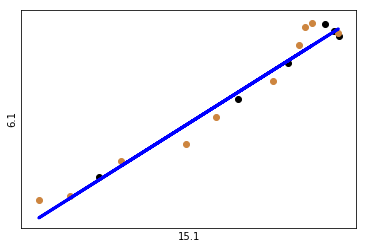

15.1 6.1
MAE: 0.19083
RMSE: 0.22079
R2: 0.952
Coefficient 0.9800404192038871
--------------------------


15.1 9.5
MAE: 0.28988
RMSE: 0.31702
R2: 0.890
Coefficient 1.0658219443520722
--------------------------


15.1 15.4
MAE: 0.17109
RMSE: 0.19763
R2: 0.961
Coefficient 1.0115725339617843
--------------------------


15.1 3.6
MAE: 2.75891
RMSE: 3.59739
R2: nan
Coefficient -2.118925034892011
--------------------------


15.1 8.2
MAE: 0.88027
RMSE: 1.10922
R2: 0.000
Coefficient -0.020694254465738766
--------------------------


15.1 17.19
MAE: 1.20313
RMSE: 1.33092
R2: 0.000
Coefficient 0.5022992321791228
--------------------------




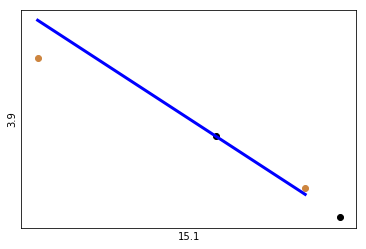

15.1 3.9
MAE: 0.31570
RMSE: 0.38559
R2: nan
Coefficient -0.958099520661679
--------------------------


15.1 3.3
MAE: 0.48576
RMSE: 0.55442
R2: 0.593
Coefficient -1.0833444547647348
--------------------------


15.1 9.4
MAE: 0.23474
RMSE: 0.27664
R2: 0.917
Coefficient 1.0821165064660938
--------------------------


15.1 16.a
MAE: 1.24498
RMSE: 1.50363
R2: 0.000
Coefficient 0.0
--------------------------


15.1 3.4
MAE: 0.72240
RMSE: 0.78943
R2: nan
Coefficient -1.1596556201799118
--------------------------


15.1 17.2
MAE: 0.30362
RMSE: 0.36183
R2: 0.846
Coefficient 1.0527616396627022
--------------------------


15.1 14.5
MAE: 1.65006
RMSE: 1.72120
R2: 0.000
Coefficient 0.0
--------------------------


15.1 2.1
MAE: 0.29407
RMSE: 0.36643
R2: 0.650
Coefficient -0.7310105235835768
--------------------------


15.1 8.1
MAE: 0.87227
RMSE: 1.16546
R2: 0.000
Coefficient -0.015812857885936987
--------------------------


15.1 17.3
MAE: 0.15154
RMSE: 0.19040
R2: 0.960
Coefficient 1.0008110016

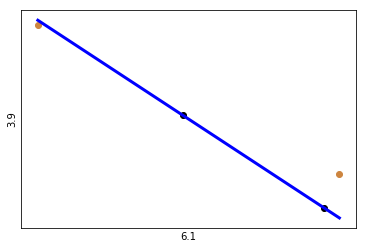

6.1 3.9
MAE: 0.30270
RMSE: 0.38638
R2: nan
Coefficient -0.9391958355831733
--------------------------


6.1 3.3
MAE: 0.46962
RMSE: 0.51983
R2: 0.642
Coefficient -1.0953716134604414
--------------------------


6.1 9.4
MAE: 0.22103
RMSE: 0.27689
R2: 0.917
Coefficient 1.0754468996463775
--------------------------


6.1 16.a
MAE: 0.44110
RMSE: 0.44204
R2: nan
Coefficient 0.7434920601495291
--------------------------


6.1 3.4
MAE: 0.70666
RMSE: 0.74639
R2: nan
Coefficient -1.1367751529939345
--------------------------


6.1 17.2
MAE: 0.25690
RMSE: 0.32096
R2: 0.878
Coefficient 0.8755253919357887
--------------------------


6.1 14.5
MAE: 1.34518
RMSE: 1.37047
R2: nan
Coefficient 1.455306177976042
--------------------------


6.1 2.1
MAE: 0.28070
RMSE: 0.31082
R2: 0.748
Coefficient -0.7496696655656743
--------------------------


6.1 8.1
MAE: 0.86657
RMSE: 1.15504
R2: 0.000
Coefficient -0.05102648728582645
--------------------------




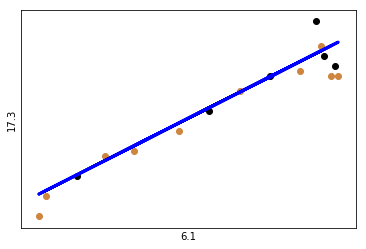

6.1 17.3
MAE: 0.21758
RMSE: 0.29100
R2: 0.907
Coefficient 0.9861695019657947
--------------------------


6.1 6.2
MAE: 0.34068
RMSE: 0.38443
R2: 0.816
Coefficient -1.080985551945865
--------------------------


6.1 14.4
MAE: 0.73454
RMSE: 0.81181
R2: 0.233
Coefficient 1.1039356252876424
--------------------------


6.1 3.1
MAE: 0.54094
RMSE: 0.56291
R2: nan
Coefficient -1.0777885009834347
--------------------------


6.1 7.2
MAE: 0.74755
RMSE: 0.85369
R2: 0.145
Coefficient 0.7432152381887653
--------------------------


6.1 10.c
MAE: 0.61913
RMSE: 0.62674
R2: 0.000
Coefficient 14.208968351315429
--------------------------


6.1 12.2
MAE: 0.19696
RMSE: 0.25467
R2: 0.922
Coefficient 1.1758909257946843
--------------------------


6.1 9.2
MAE: 0.50128
RMSE: 0.74212
R2: 0.306
Coefficient 1.0994968959314442
--------------------------


6.1 7.1
MAE: 0.83735
RMSE: 0.84033
R2: nan
Coefficient 1.2504131723673149
--------------------------


6.1 9.c
MAE: 0.43389
RMSE: 0.63928
R2: 0.553
Coefficie

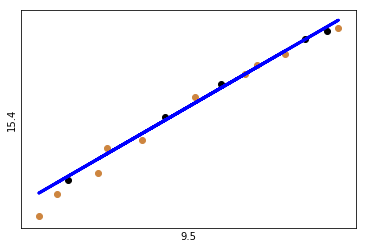

9.5 15.4
MAE: 0.12440
RMSE: 0.15691
R2: 0.972
Coefficient 0.9031785631711373
--------------------------


9.5 3.6
MAE: 1.43774
RMSE: 1.95252
R2: nan
Coefficient -1.34414085516827
--------------------------


9.5 8.2
MAE: 0.93076
RMSE: 1.14613
R2: 0.000
Coefficient -0.059789800025135814
--------------------------


9.5 17.19
MAE: 1.22166
RMSE: 1.35177
R2: 0.000
Coefficient 0.2226967324463827
--------------------------




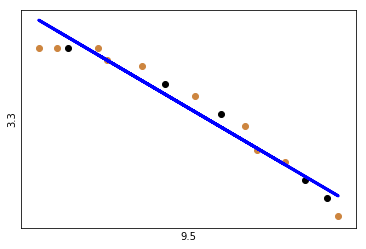

9.5 3.3
MAE: 0.18975
RMSE: 0.23249
R2: 0.928
Coefficient -0.9320193435702896
--------------------------




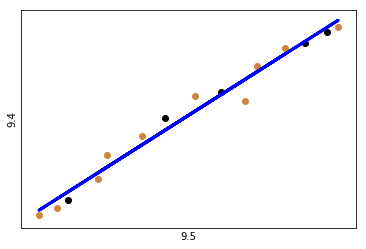

9.5 9.4
MAE: 0.14794
RMSE: 0.16655
R2: 0.970
Coefficient 0.9865437079530124
--------------------------


9.5 17.2
MAE: 0.32454
RMSE: 0.40380
R2: 0.807
Coefficient 0.6943992205888337
--------------------------


9.5 2.1
MAE: 0.13648
RMSE: 0.16621
R2: 0.928
Coefficient -0.6599776881585806
--------------------------


9.5 8.1
MAE: 0.87925
RMSE: 1.14919
R2: 0.004
Coefficient -0.09573597297973793
--------------------------


9.5 17.3
MAE: 0.21939
RMSE: 0.30368
R2: 0.899
Coefficient 0.7847527893650187
--------------------------




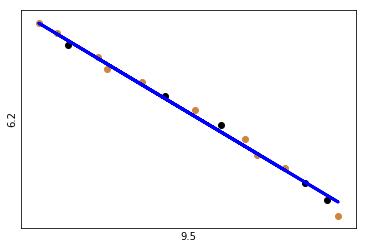

9.5 6.2
MAE: 0.06202
RMSE: 0.08373
R2: 0.991
Coefficient -0.909344737992069
--------------------------


9.5 14.4
MAE: 0.59173
RMSE: 0.64033
R2: 0.523
Coefficient 0.7485005411121101
--------------------------


9.5 7.2
MAE: 0.64489
RMSE: 0.73958
R2: 0.358
Coefficient 0.8385773299941104
--------------------------


9.5 10.c
MAE: 0.54602
RMSE: 0.59105
R2: nan
Coefficient -3.072810754449695
--------------------------


9.5 12.2
MAE: 0.24908
RMSE: 0.29219
R2: 0.897
Coefficient 1.4565766850612982
--------------------------




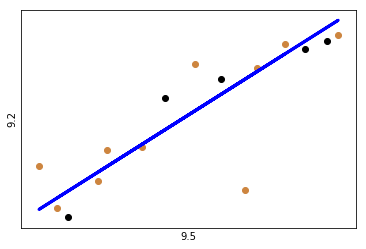

9.5 9.2
MAE: 0.38389
RMSE: 0.59469
R2: 0.555
Coefficient 0.9230764173180972
--------------------------


9.5 7.1
MAE: 0.08977
RMSE: 0.11913
R2: nan
Coefficient 0.8269159981686063
--------------------------




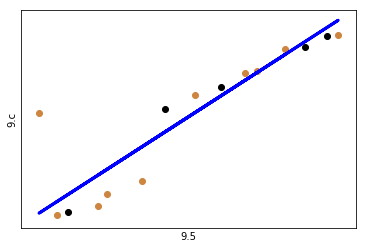

9.5 9.c
MAE: 0.36444
RMSE: 0.53659
R2: 0.685
Coefficient 0.9557834695318665
--------------------------


9.5 8.4
MAE: 0.24908
RMSE: 0.29219
R2: 0.897
Coefficient 1.4565766850612982
--------------------------




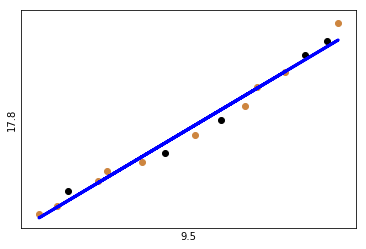

9.5 17.8
MAE: 0.08920
RMSE: 0.11761
R2: 0.982
Coefficient 0.9018945485960709
--------------------------


15.4 3.6
MAE: 1.69357
RMSE: 2.20051
R2: nan
Coefficient -1.4605258942117925
--------------------------


15.4 8.2
MAE: 0.85613
RMSE: 1.10328
R2: 0.000
Coefficient -0.13287870443029942
--------------------------


15.4 17.19
MAE: 1.22539
RMSE: 1.35765
R2: 0.000
Coefficient 0.27196612136662396
--------------------------


15.4 3.9
MAE: 0.18710
RMSE: 0.24335
R2: nan
Coefficient -0.669367034303834
--------------------------


15.4 3.3
MAE: 0.31138
RMSE: 0.39446
R2: 0.794
Coefficient -1.1318151500375628
--------------------------


15.4 9.4
MAE: 0.15440
RMSE: 0.18554
R2: 0.963
Coefficient 1.0942693725829544
--------------------------


15.4 16.a
MAE: 23.43373
RMSE: 26.61758
R2: 0.000
Coefficient 14.200082251154083
--------------------------


15.4 3.4
MAE: 0.17608
RMSE: 0.23258
R2: nan
Coefficient -0.8101822687036941
--------------------------


15.4 17.2
MAE: 0.27085
RMSE: 0.37449
R2: 

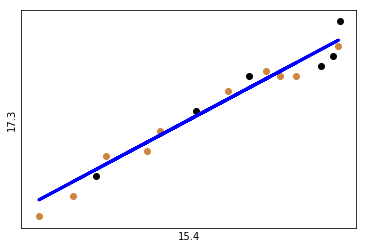

15.4 17.3
MAE: 0.15751
RMSE: 0.17052
R2: 0.968
Coefficient 0.9679870517481235
--------------------------


15.4 6.2
MAE: 0.18580
RMSE: 0.22088
R2: 0.939
Coefficient -1.1022244446724394
--------------------------


15.4 14.4
MAE: 0.71864
RMSE: 0.73295
R2: 0.375
Coefficient 0.8991469918411162
--------------------------


15.4 3.1
MAE: 0.09488
RMSE: 0.09606
R2: nan
Coefficient -0.7681423460125294
--------------------------


15.4 7.2
MAE: 0.71627
RMSE: 0.82794
R2: 0.196
Coefficient 0.8762400754990601
--------------------------


15.4 10.c
MAE: 1.84248
RMSE: 2.21084
R2: 0.000
Coefficient -14.00668496469951
--------------------------


15.4 12.2
MAE: 0.22897
RMSE: 0.28144
R2: 0.904
Coefficient 1.402433507508545
--------------------------


15.4 9.2
MAE: 0.40024
RMSE: 0.63261
R2: 0.525
Coefficient 1.0966156722630638
--------------------------




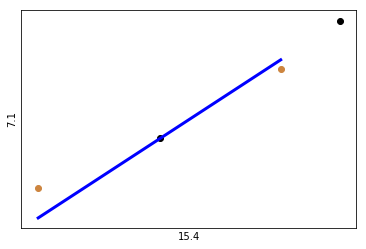

15.4 7.1
MAE: 0.26745
RMSE: 0.30264
R2: nan
Coefficient 0.9258973056119334
--------------------------


15.4 9.c
MAE: 0.33914
RMSE: 0.61456
R2: 0.587
Coefficient 1.0452380825578427
--------------------------


15.4 8.4
MAE: 0.22897
RMSE: 0.28144
R2: 0.904
Coefficient 1.402433507508545
--------------------------


15.4 17.8
MAE: 0.21765
RMSE: 0.26387
R2: 0.911
Coefficient 1.1074147893315365
--------------------------


3.6 8.2
MAE: 0.98236
RMSE: 1.10493
R2: nan
Coefficient 0.2881645257312029
--------------------------


3.6 3.3
MAE: 0.79148
RMSE: 1.02957
R2: nan
Coefficient 0.8405705943867494
--------------------------


3.6 9.4
MAE: 1.13884
RMSE: 1.50374
R2: nan
Coefficient -0.6513341917602673
--------------------------


3.6 17.2
MAE: 1.16479
RMSE: 1.59537
R2: nan
Coefficient -0.1255798469028086
--------------------------


3.6 2.1
MAE: 0.59801
RMSE: 0.69319
R2: nan
Coefficient 0.5922963994530965
--------------------------


3.6 8.1
MAE: 0.84446
RMSE: 0.84674
R2: nan
Coefficient 0.340

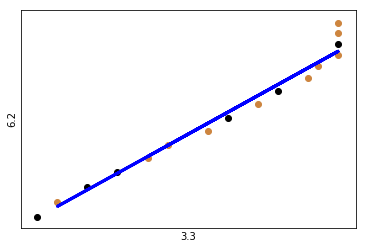

3.3 6.2
MAE: 0.13926
RMSE: 0.19412
R2: 0.953
Coefficient 0.9565934111758428
--------------------------


3.3 14.4
MAE: 0.60826
RMSE: 0.64595
R2: 0.514
Coefficient -0.6666816119503871
--------------------------


3.3 3.1
MAE: 0.45782
RMSE: 0.58977
R2: nan
Coefficient 0.5279665018933217
--------------------------


3.3 7.2
MAE: 0.54699
RMSE: 0.59619
R2: 0.583
Coefficient -1.001027114267096
--------------------------


3.3 10.c
MAE: 0.62766
RMSE: 0.71430
R2: 0.000
Coefficient 3.2970404715917043
--------------------------


3.3 12.2
MAE: 0.53388
RMSE: 0.59685
R2: 0.570
Coefficient -2.231037706950077
--------------------------


3.3 9.2
MAE: 0.38445
RMSE: 0.55341
R2: 0.614
Coefficient -0.8171112908084333
--------------------------


3.3 7.1
MAE: 0.26576
RMSE: 0.34240
R2: nan
Coefficient -0.6828081837478072
--------------------------


3.3 9.c
MAE: 0.44174
RMSE: 0.48450
R2: 0.743
Coefficient -0.8213585424883107
--------------------------


3.3 8.4
MAE: 0.53388
RMSE: 0.59685
R2: 0.570
Coeffic

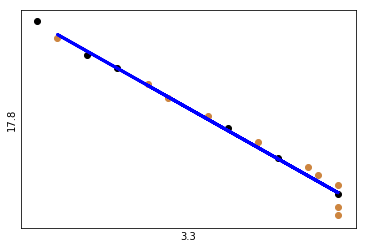

3.3 17.8
MAE: 0.11959
RMSE: 0.15730
R2: 0.968
Coefficient -0.9773686953752095
--------------------------


9.4 17.2
MAE: 0.31334
RMSE: 0.37605
R2: 0.833
Coefficient 0.7276401493722522
--------------------------


9.4 2.1
MAE: 0.20236
RMSE: 0.23566
R2: 0.855
Coefficient -0.6464032188731045
--------------------------


9.4 8.1
MAE: 0.89059
RMSE: 1.16773
R2: 0.000
Coefficient -0.04974666236196581
--------------------------


9.4 17.3
MAE: 0.22295
RMSE: 0.30057
R2: 0.901
Coefficient 0.8046264761285795
--------------------------




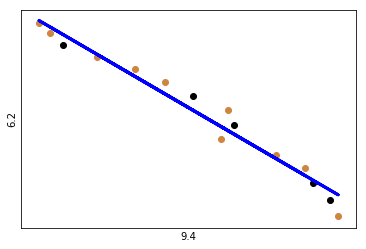

9.4 6.2
MAE: 0.14356
RMSE: 0.17332
R2: 0.963
Coefficient -0.9041987684604177
--------------------------


9.4 14.4
MAE: 0.75816
RMSE: 0.76315
R2: 0.322
Coefficient 0.8984980984423889
--------------------------


9.4 7.2
MAE: 0.74157
RMSE: 0.82041
R2: 0.210
Coefficient 0.767161222308168
--------------------------


9.4 10.c
MAE: 0.40131
RMSE: 0.40488
R2: nan
Coefficient -3.916067094972819
--------------------------


9.4 12.2
MAE: 0.07592
RMSE: 0.08359
R2: 0.992
Coefficient 1.27592653500619
--------------------------




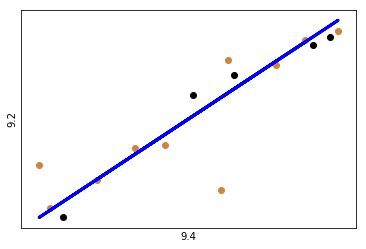

9.4 9.2
MAE: 0.29835
RMSE: 0.49544
R2: 0.691
Coefficient 0.9598371559007554
--------------------------




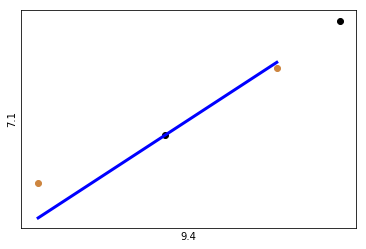

9.4 7.1
MAE: 0.28048
RMSE: 0.34757
R2: nan
Coefficient 0.954187317475595
--------------------------




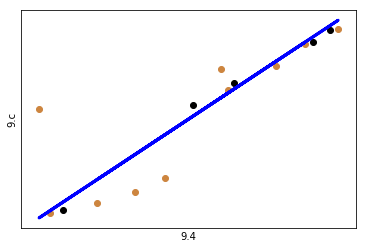

9.4 9.c
MAE: 0.37700
RMSE: 0.58446
R2: 0.626
Coefficient 0.9815068607139434
--------------------------


9.4 8.4
MAE: 0.07592
RMSE: 0.08359
R2: 0.992
Coefficient 1.27592653500619
--------------------------


9.4 17.8
MAE: 0.15876
RMSE: 0.19610
R2: 0.951
Coefficient 0.8886069421260533
--------------------------


16.a 3.4
MAE: 0.75067
RMSE: 0.86718
R2: nan
Coefficient -1.5289674415155279
--------------------------


16.a 17.2
MAE: 4.04704
RMSE: 4.94382
R2: 0.000
Coefficient 4.5731781994648575
--------------------------


16.a 14.5
MAE: 0.71269
RMSE: 0.76867
R2: 0.000
Coefficient 1.3508829873970554
--------------------------


16.a 2.1
MAE: 1.18327
RMSE: 1.66345
R2: nan
Coefficient -1.7565932966332185
--------------------------


16.a 8.1
MAE: 0.58478
RMSE: 0.59506
R2: nan
Coefficient -0.6430646451598453
--------------------------


16.a 17.3
MAE: 0.88685
RMSE: 1.06184
R2: nan
Coefficient 2.09492880270664
--------------------------


16.a 6.2
MAE: 1.46885
RMSE: 1.82368
R2: nan
Coefficien

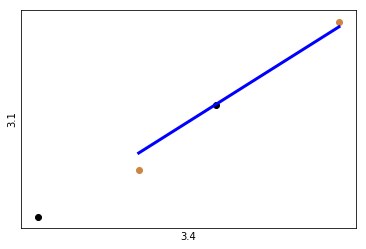

3.4 3.1
MAE: 0.12905
RMSE: 0.14781
R2: nan
Coefficient 0.9481105372024129
--------------------------


3.4 9.2
MAE: 0.65800
RMSE: 0.71987
R2: nan
Coefficient -1.264637653632074
--------------------------


3.4 9.c
MAE: 1.57295
RMSE: 1.80539
R2: nan
Coefficient -1.514210515120141
--------------------------


3.4 17.8
MAE: 0.48247
RMSE: 0.61177
R2: nan
Coefficient -1.6825727022495645
--------------------------


17.2 14.5
MAE: 1.16371
RMSE: 1.21206
R2: 0.000
Coefficient 0.2953925975495843
--------------------------


17.2 2.1
MAE: 0.24891
RMSE: 0.38008
R2: 0.623
Coefficient -0.7503123649511201
--------------------------


17.2 8.1
MAE: 0.88922
RMSE: 1.19538
R2: 0.000
Coefficient 0.08429096060971214
--------------------------


17.2 17.3
MAE: 0.26871
RMSE: 0.38985
R2: 0.833
Coefficient 1.086207256670937
--------------------------


17.2 6.2
MAE: 0.34137
RMSE: 0.45321
R2: 0.744
Coefficient -1.1532419807312728
--------------------------


17.2 14.4
MAE: 1.59136
RMSE: 1.84668
R2: 0.000
Coeff

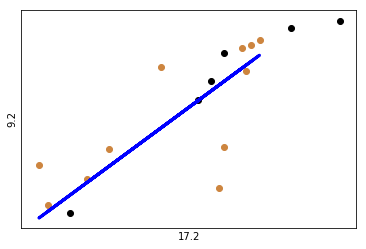

17.2 9.2
MAE: 0.49823
RMSE: 0.67874
R2: 0.453
Coefficient 0.9806018989846819
--------------------------


17.2 7.1
MAE: 3.76891
RMSE: 5.30179
R2: nan
Coefficient 3.9278176446024764
--------------------------


17.2 9.c
MAE: 0.50086
RMSE: 0.77962
R2: 0.335
Coefficient 1.130314558116212
--------------------------


17.2 8.4
MAE: 0.33715
RMSE: 0.47417
R2: 0.728
Coefficient 1.18158159259803
--------------------------


17.2 17.8
MAE: 0.36194
RMSE: 0.47955
R2: 0.705
Coefficient 1.1404961089395398
--------------------------


14.5 2.1
MAE: 0.17326
RMSE: 0.19459
R2: nan
Coefficient -0.8974147081372347
--------------------------


14.5 8.1
MAE: 0.47986
RMSE: 0.49570
R2: nan
Coefficient -0.328531181324436
--------------------------


14.5 17.3
MAE: 0.62059
RMSE: 0.87240
R2: nan
Coefficient 1.070264769683804
--------------------------


14.5 6.2
MAE: 0.32248
RMSE: 0.42622
R2: nan
Coefficient -1.2468960869304861
--------------------------


14.5 3.1
MAE: 0.45529
RMSE: 0.57416
R2: nan
Coefficient 

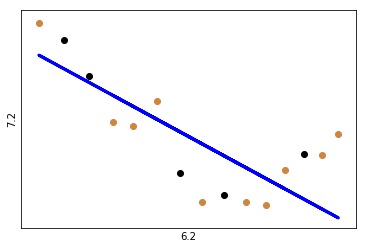

6.2 7.2
MAE: 0.64134
RMSE: 0.73169
R2: 0.372
Coefficient -0.9726203107637379
--------------------------


6.2 10.c
MAE: 0.48276
RMSE: 0.59584
R2: 0.000
Coefficient 3.4039458609281334
--------------------------


6.2 12.2
MAE: 0.27786
RMSE: 0.33801
R2: 0.862
Coefficient -1.7420565045273626
--------------------------


6.2 9.2
MAE: 0.39005
RMSE: 0.55764
R2: 0.608
Coefficient -0.8827844930287393
--------------------------


6.2 7.1
MAE: 0.05737
RMSE: 0.06046
R2: nan
Coefficient -0.7978678300733478
--------------------------


6.2 9.c
MAE: 0.44426
RMSE: 0.53994
R2: 0.681
Coefficient -0.8805009669859916
--------------------------


6.2 8.4
MAE: 0.27786
RMSE: 0.33801
R2: 0.862
Coefficient -1.7420565045273626
--------------------------


6.2 17.8
MAE: 0.04623
RMSE: 0.05364
R2: 0.996
Coefficient -1.0163532723183002
--------------------------


14.4 7.2
MAE: 1.73969
RMSE: 2.04093
R2: 0.000
Coefficient 2.343282038997347
--------------------------


14.4 12.2
MAE: 1.08432
RMSE: 1.23373
R2: 0.000


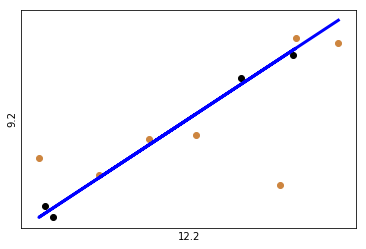

12.2 9.2
MAE: 0.43833
RMSE: 0.66775
R2: 0.052
Coefficient 0.9091102477352295
--------------------------


12.2 9.c
MAE: 0.50360
RMSE: 0.67827
R2: 0.264
Coefficient 0.8621500724721457
--------------------------


12.2 8.4
MAE: 0.00000
RMSE: 0.00000
R2: 1.000
Coefficient 1.0
--------------------------


12.2 17.8
MAE: 0.17688
RMSE: 0.22951
R2: 0.859
Coefficient 0.49164504738278997
--------------------------




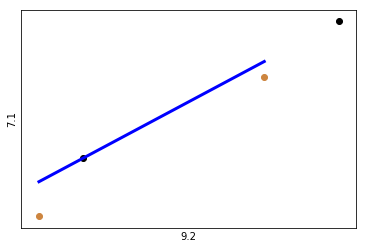

9.2 7.1
MAE: 0.29007
RMSE: 0.30911
R2: nan
Coefficient 0.993523828183931
--------------------------




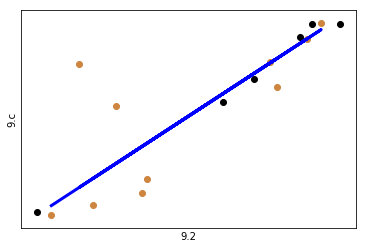

9.2 9.c
MAE: 0.45766
RMSE: 0.66334
R2: 0.518
Coefficient 0.9747028691282287
--------------------------


9.2 8.4
MAE: 0.48226
RMSE: 0.73341
R2: 0.350
Coefficient 1.0899953580212127
--------------------------




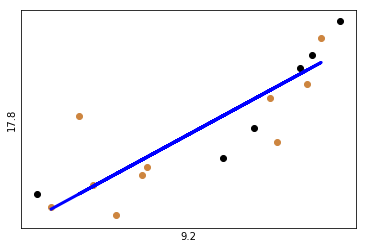

9.2 17.8
MAE: 0.40281
RMSE: 0.56218
R2: 0.595
Coefficient 0.9545872364911525
--------------------------


7.1 9.c
MAE: 1.11652
RMSE: 1.35892
R2: nan
Coefficient 1.340800257029588
--------------------------


7.1 17.8
MAE: 0.10671
RMSE: 0.10671
R2: nan
Coefficient 1.3093853865981069
--------------------------


9.c 8.4
MAE: 0.58385
RMSE: 0.78624
R2: 0.253
Coefficient 1.1585232669942755
--------------------------




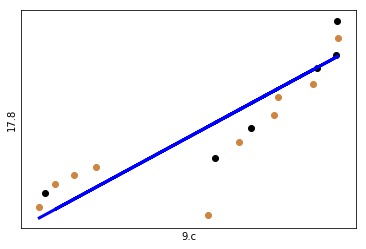

9.c 17.8
MAE: 0.43124
RMSE: 0.55489
R2: 0.605
Coefficient 0.9935715813066376
--------------------------


8.4 17.8
MAE: 0.17688
RMSE: 0.22951
R2: 0.859
Coefficient 0.49164504738278997
--------------------------




In [25]:
keptPairs = list()
processedPairs = list()
discardedPairs = list()
edgecolor = list()
pairsAndRel = {}

n_connections = 0

for targetx in targets:     #loop over all columns
        
        for targety in targets:    #loop over all columns except the one we're in now
            # avoid double processing of reverse pairs
            if not set([targetx, targety]) in processedPairs:
                processedPairs.extend([set([targetx, targety])])
                
                if not targety==targetx:


                    X = final_t_shuffled[targetx].reshape(-1,1)
                    Y = final_t_shuffled[targety].reshape(-1,1)

                    # apply mask to lists to filter out pairs containing any NaNs
                    mask = ~pd.isnull(X) & ~pd.isnull(Y)

                    X = X[mask]
                    Y = Y[mask]


                    # Split the data into training/validation sets
                    split = math.floor(2/3 * len(X))
                    X_train = X[:-split]
                    Y_train = Y[:-split]

                    X_valid = X[-split:]
                    Y_valid = Y[-split:]


                    if (len(X_train) > 1):

                        X_train = X_train.reshape(-1, 1)
                        Y_train = Y_train.reshape(-1, 1)
                        
                        X_valid = X_valid.reshape(-1, 1)
                        Y_valid = Y_valid.reshape(-1, 1)

                        linreg = linear_model.LinearRegression()
                        linreg.fit(X_train, Y_train)
                        
                        # Make predictions using the validation values
                        y_pred = linreg.predict(X_valid)
                        mae, rae, rmse, r2 = compute_error(Y_valid, y_pred)
                        
                        
                        coef = linreg.coef_[0][0]
                        
                        # filter out independant variables (coefficient close to 0, coefficient > 100)
                        if (0.9 < np.abs(coef) < 1):
                            
                            keptPairs.extend([tuple((targetx, targety))])

                            if coef > 0: edge_color = 'g'#edgecolor.append('g')
                            else: edge_color = 'r'
                                    
                            edgecolor.append(edge_color)
                            pairsAndRel[targetx, targety] = edge_color

                            plt.scatter(X_train, Y_train,  color='black')
                            plt.scatter(X_valid, Y_valid, color='peru')
                            plt.plot(X_valid, y_pred, color='blue', linewidth=3)

                            plt.xticks(())
                            plt.yticks(())
                            plt.xlabel(targetx)
                            plt.ylabel(targety)
                            plt.show()

                            n_connections = n_connections + 1

                        else: discardedPairs.extend([[targetx, targety]])

                        print(targetx, targety)
                        
                        print("MAE: %.5f\nRMSE: %.5f\nR2: %.3f" % (mae, rmse, r2))
                        print('Coefficient', coef)
                        print('--------------------------')
                        print('\n')

#print(keptPairs)

In [26]:
print("Total number of connections found: ", n_connections)

Total number of connections found:  27


In [27]:
#print(keptPairs)

In [28]:
# seems like the high value targets are discarded more than the others, else, evenly distributed
#print(discardedPairs)

## 2. Graphical Models

In [29]:
import networkx as nx

In [30]:
G1 = nx.Graph()
G1.add_edges_from(keptPairs)

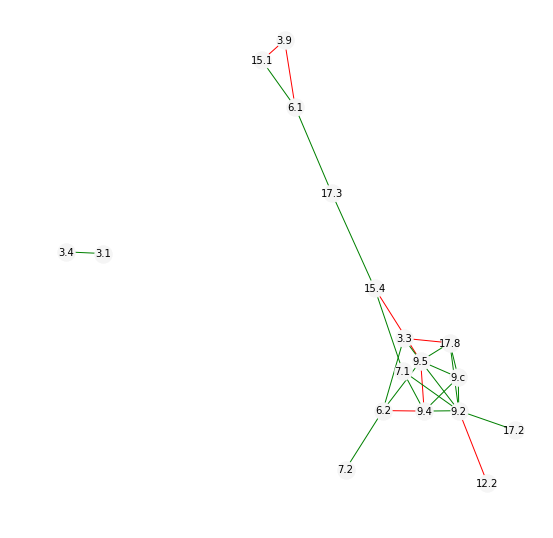

In [31]:
pos2 = nx.spring_layout(G1) # choose layout

plt.figure(1,figsize=(7,7)) 
nx.draw(G1,pos2, with_labels=True, edge_color=edgecolor, node_color='whitesmoke', font_size=10)
plt.savefig("structure.png")
plt.show()

In this plot, the most connected and therefore most influential nodes are located in the middle of the graph.

In [32]:
from matplotlib.pyplot import imshow
%matplotlib inline
from PIL import Image

size = 1024,1024
circles = Image.open("Circle-Designs-01.png")
circles = circles.resize(size, Image.ANTIALIAS)
plot = Image.open("structure.png")
plot = plot.resize(size, Image.ANTIALIAS)
overlay = Image.blend(circles, plot,alpha=0.7)
#overlay.show()
#overlay.save("final.png")

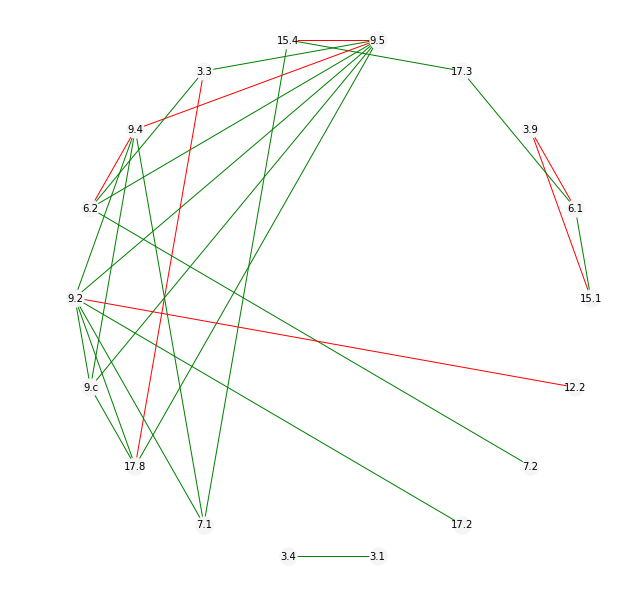

In [33]:
pos = nx.circular_layout(G1) # choose layout
# default
plt.figure(1,figsize=(8,8)) 
nx.draw(G1,pos, with_labels=True, edge_color=edgecolor, node_color='whitesmoke', font_size=10)
plt.show()

In [34]:
clique_list = list(nx.find_cliques(G1))
clique_list

[['15.1', '3.9', '6.1'],
 ['6.1', '17.3'],
 ['17.3', '15.4'],
 ['9.5', '3.3', '17.8'],
 ['9.5', '3.3', '6.2'],
 ['9.5', '15.4'],
 ['9.5', '9.4', '6.2'],
 ['9.5', '9.4', '9.c', '9.2'],
 ['9.5', '17.8', '9.c', '9.2'],
 ['12.2', '9.2'],
 ['7.1', '9.4', '9.2'],
 ['7.1', '15.4'],
 ['3.4', '3.1'],
 ['17.2', '9.2'],
 ['7.2', '6.2']]

In [35]:
# finding clique containing most nodes
length = 0
for c in clique_list:
    if len(c) > length:
        length = len(c)
        max_clique = c

In [36]:
import itertools

def complete_graph_from_list(L, create_using=None):
    G = nx.empty_graph()
    if len(L)>1:
        if G.is_directed():
            edges = itertools.permutations(L,2)
        else:
            edges = itertools.combinations(L,2)
        G.add_edges_from(edges)
    return G


In [37]:
cliqueGraph = complete_graph_from_list(max_clique)

In [38]:
cliqueGraph_edges = list(cliqueGraph.edges)
pairsDictListKeys = list(pairsAndRel.keys())

In [39]:
clique_e_color = []
for edge in cliqueGraph_edges:
    if edge in pairsDictListKeys:
        clique_e_color.append(pairsAndRel[edge])
    elif edge[::-1] in pairsDictListKeys:
        clique_e_color.append(pairsAndRel[edge[::-1]])

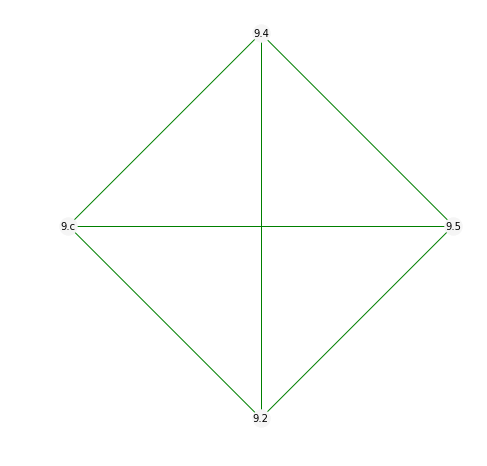

In [40]:
#cliqueGraph.add_nodes_from(max_clique)
pos9 = nx.shell_layout(cliqueGraph)
plt.figure(1,figsize=(6,6)) 
nx.draw(cliqueGraph,pos9, with_labels=True, font_size=10, edge_color=clique_e_color, node_color='whitesmoke')
plt.show()

# 2. Build temporal model to infer missing observations

We have a temporal model with missing observations as NaNs, and want to infer them.

## Define STAN model

From now on, we can actually forget all information we've gotten so far. With the implementation in STAN, we will gain insights for the following two questions in one single model (wow - so amazing :-) ):

**1. How are Targets correlated?**

**2. What are expectable values for missing observations (imputing)?**

Note that we observe two time-series simultaneously. We will model the correlations between the two time-series in the latent state $\textbf{z}_t$. We will assume that our latent state is 2-dimensional $\textbf{z}_t = \{z_{t,1},z_{t,2}\}$ with latent dynamics:
\begin{align}
\textbf{z}_t &\sim \mathcal{N}(\boldsymbol\beta \textbf{z}_{t-1}, \boldsymbol\Sigma)
\end{align}
And likelihoods:
\begin{align}
y_{t,1} &\sim \mathcal{N}(z_{t,1}, \sigma^2)\\
y_{t,2} &\sim \mathcal{N}(z_{t,2}, \sigma^2)
\end{align}
Or (equivalent):
\begin{align}
\textbf{y}_t &\sim \mathcal{N}(\textbf{z}_t, \sigma^2 \textbf{I})
\end{align}

The key element in the model described above is the **covariance matrix $\boldsymbol\Sigma$** which embodies the object that will allow us to capture the correlations between the two time-series.

In STAN, the recommended approach is to decompose the covariance matrix $\boldsymbol\Sigma$ into a *scale* and a *matrix*, but we are able to do so in a more natural way based on the actual variable scales and a correlation matrix. Specifically, we define:

\begin{align}
\boldsymbol\Sigma = \mbox{diag_matrix}(\boldsymbol\tau) \, \boldsymbol\Omega \, \mbox{diag_matrix}(\boldsymbol\tau)
\end{align}

where $\mbox{diag_matrix}(\boldsymbol\tau)$ denotes a diagonal matrix with diagonal elements given by the vector $\boldsymbol\tau$. In this parameterization, $\boldsymbol\Omega$ can be regarded as a correlation matrix and $\boldsymbol\tau$ is a vector of coefficient scales.

Similar to any other variable, we also must assign priors to $\boldsymbol\tau$ and $\boldsymbol\Omega$. The components of the scale vector $\boldsymbol\tau$ can be given any reasonable prior for scales, but something weakly informative like a half-Cauchy distribution with a small scale is recommended, such as:

\begin{align}
\boldsymbol\tau ∼ Cauchy(0, 1.0) , \, \mbox{with the constraint:} \, \boldsymbol\tau > 0
\end{align}

As for the correlation matrix $\boldsymbol\Omega$, the STAN manual recommends a LKJ prior like:

\begin{align}
\boldsymbol\Omega ∼ LKJCorr(10.0)
\end{align}

Finally, we can define a multivariate Gaussian with parameters $\boldsymbol\mu$, $\boldsymbol\tau$ and $\boldsymbol\Omega$ using:

    multi_normal(mu, quad_form_diag(Omega, tau))


To impute missing observations, we do

\begin{align}
y_{t} &\sim \mathcal{N} \Big(\beta_{1} y_{t-1} + \beta_{2} y_{t-2} + ... + \beta_{T} y_{t-T} \Big)
\end{align}


**Note** that we want to make the missing observation dependent on two previous observations. This is equivalent to define an autoregressive model of order 2.

In [41]:
SDG_STAN="""
data {
    int<lower = 0> N_obs1;
    int<lower = 0> N_mis1;    // how many do we want to infer
    int<lower = 0> N_obs2;  
    int<lower = 0> N_mis2;
    int<lower = 1, upper = N_obs1 + N_mis1> ix_obs1[N_obs1];    // index for observed time steps of target 1
    int<lower = 1, upper = N_obs1 + N_mis1> ix_mis1[N_mis1];
    int<lower = 1, upper = N_obs2 + N_mis2> ix_obs2[N_obs2];    // index for observed time steps of target 2
    int<lower = 1, upper = N_obs2 + N_mis2> ix_mis2[N_mis2];
    real y_obs1[N_obs1];         // observed time-series data for target 1
    real y_obs2[N_obs2];         // observed time-series data for target 2
}

transformed data {
    int<lower = 0> T = N_obs1 + N_mis1;  // length of the time-series
}

parameters {
    vector[2] beta[2];            // state transition coefficients 
    corr_matrix[2] Omega;       // gives us the correlation with **Omega[1,2]=Omega[2,1]=Cov(1,2)**; Omega[1,1]=Var(1);Omega[2,2]=Var(2)    1 is target 1, 2 is target 2
    vector<lower=0>[2] tau;     // uncertainty in the latent space
    real<lower=0> sigma;       // observation noise
    matrix[T,2] z;             // vector of latent states
    real y_mis1[N_mis1];        // missing time-series data to infer for target 1
    real y_mis2[N_mis2];        // missing time-series data to infer for target 2
}

transformed parameters {
    real y1[T];
    real y2[T];
    matrix[2,2] L_sigma;
    y1[ix_obs1] = y_obs1;
    y1[ix_mis1] = y_mis1;
    y2[ix_obs2] = y_obs2;
    y2[ix_mis2] = y_mis2;
}

model {
    for(i in 1:2)                   
        beta[i] ~ normal(0,1);            // prior on the auto-regressive coefficients
    tau ~ cauchy(0,1);
    Omega ~ lkj_corr(1);         // STAN manual Section 63.1 (recommendation is lkj_corr)
    sigma ~ cauchy(0,5);            // prior on the variance
    
    z[1,:] ~ normal(0,1);           // prior on first latent state
    z[2,:] ~ normal(0,1);           // prior on second latent state
    
    for(t in 3:T) {
        vector[2] mu;                          // mu is a vector of the means of our multivariate normal 
        mu[1] = beta[1]' * z[(t-2):(t-1),1];   // mu[1] is the mean of target 1 
        mu[2] = beta[2]' * z[(t-2):(t-1),2];   // mu[2] is the mean of target 2
        z[t,:] ~ multi_normal(mu, quad_form_diag(Omega, tau)); // latent dynamics
    }
    
    y1 ~ normal(z[:,1], sigma);    // likelihood for target 1
    y2 ~ normal(z[:,2], sigma);    // likelihood for target 2
}
"""

### What targets are in our clique?

We will work for the rest of the notebook with this single clique.

In [42]:
clique_nodes = list(cliqueGraph.nodes)
clique_nodes

['9.5', '9.4', '9.c', '9.2']

In [43]:
clique_df_t = final_t[clique_nodes]

In [44]:
clique_df_t = clique_df_t[clique_df_t.index > '1990']

## What is observed, what is missing?

- N_obs: Number of observed values (length of loc array)
- N_mis: Number of missing values (length of loc array)
- ix_obs: indices of observed values
- ix_mis: indices of missing values
- y_obs: observed values

In [45]:
# prepare data for STAN model
def prepareInputData(df, target1, target2):
    t1_list = df[target1].tolist()
    t2_list = df[target2].tolist()
    
    ix_obs1 = np.where(~np.isnan(t1_list))[0]
    ix_obs2 = np.where(~np.isnan(t2_list))[0]
    
    ix_mis1 = np.where(np.isnan(t1_list))[0]
    ix_mis2 = np.where(np.isnan(t2_list))[0]
    
    y_obs1 = [t1_list[index] for index in ix_obs1]
    y_obs2 = [t2_list[index] for index in ix_obs2]
    
    N_obs1 = len(ix_obs1)
    N_obs2 = len(ix_obs2)
    
    N_mis1 = len(ix_mis1)
    N_mis2 = len(ix_mis2)
    
    data = {'N_obs1': N_obs1, 'N_mis1': N_mis1, 'N_obs2': N_obs2, 'N_mis2': N_mis2,
            'ix_obs1': ix_obs1+1, 'ix_mis1': ix_mis1+1, 'y_obs1': y_obs1, 
            'ix_obs2': ix_obs2+1, 'ix_mis2': ix_mis2+1, 'y_obs2': y_obs2}
    
    return data

In [46]:
%%time
# create STAN model object (compile STAN model)
sm = pystan.StanModel(model_code=SDG_STAN)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_c2c8db35d3d6b106a2010ff56a7e73b8 NOW.


CPU times: user 1.7 s, sys: 75.8 ms, total: 1.77 s
Wall time: 1min 16s


### How we find the highest correlated pairs
We use here Pearson's r as a correlation coefficient what returns us *only* the pairs of random variables which are highest correlated in a linear manner. But, the world is not linear; so, we could have also used [this](http://old.econ.ucdavis.edu/faculty/cameron/research/je97preprint.pdf) correlation coefficient.

In [47]:
from scipy.stats import pearsonr

In [48]:
def calcCorr(df, target1, target2):
    # list of values
    t1_list = df[target1].tolist()
    t2_list = df[target2].tolist()
                    
    #correlation between two targets
    mask = ~pd.isnull(t1_list) & ~pd.isnull(t2_list)
    t1_list = list(itertools.compress(t1_list, mask))#t1_list[mask]
    t2_list = list(itertools.compress(t2_list, mask))

                    
    #correlation between two targets
    corrCoef = pearsonr(t1_list, t2_list)[0]
    
    return corrCoef

To find out which pairs would give the most cartain results after inference, we want to find the pairs that have the highest correlation between each other (lowest uncertainty in prediction). This is why we first calculate the correlation coefficient and choose the pairs that give the highest correlation coefficients.

In [49]:
# find pairs with best correlation coefficient
bestCorrPairs = []
processedPairs = []
corrCoefs = []

for targetx in clique_nodes:     #loop over all rows
    
    bestCorrCoef = 0
    
    for targety in clique_nodes:    #loop over all rows except the one we're in now
        # avoid double processing of reverse pairs
        if not set([targetx, targety]) in processedPairs:
            processedPairs.extend([set([targetx, targety])])
                
            if not targety==targetx:
                corr = calcCorr(clique_df_t,targetx, targety)
                if (np.abs(corr) > np.abs(bestCorrCoef) and not (corr==0 or corr==1)):
                    bestCorrCoef = corr
                    bestPair = tuple([targetx, targety])
        
        else: continue           
    
    bestCorrPairs.append(bestPair)
    corrCoefs.append(bestCorrCoef)
    
for i in range(0,len(bestCorrPairs)):
    print(bestCorrPairs[i], ': ', corrCoefs[i])

('9.5', '9.4') :  0.9880321662073264
('9.4', '9.2') :  0.8961084136207269
('9.c', '9.2') :  0.8455682975486154
('9.c', '9.2') :  0


In [50]:
# hyperparameter
startyear=1990

The predetermined pairs which have the Pearson r correlation coefficient are now taken further into account to impute values for years which we do not have observations for.

('9.4', '9.2')


/home/felix/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


Inference for Stan model: anon_model_c2c8db35d3d6b106a2010ff56a7e73b8.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
beta[0,0]     -0.58  9.0e-3   0.17  -0.86   -0.7   -0.6  -0.48  -0.18    372   1.01
beta[1,0]     -0.11    0.01   0.24  -0.56  -0.28  -0.12   0.05    0.4    312   1.01
beta[0,1]       1.5  9.0e-3   0.17   1.09    1.4   1.52   1.61   1.78    376   1.01
beta[1,1]      0.92    0.01   0.24   0.42   0.77   0.92   1.09   1.34    253   1.01
Omega[0,0]      1.0     0.0    0.0    1.0    1.0    1.0    1.0    1.0   2000    nan
Omega[1,0]     0.74  8.8e-3   0.16   0.35   0.66   0.78   0.86   0.95    340   1.01
Omega[0,1]     0.74  8.8e-3   0.16   0.35   0.66   0.78   0.86   0.95    340   1.01
Omega[1,1]      1.0 1.1e-184.7e-17    1.0    1.0    1.0    1.0    1.0   2000    nan
tau[0]         0.22  2.6e-3   0.05   0.14   0.18   0.21  

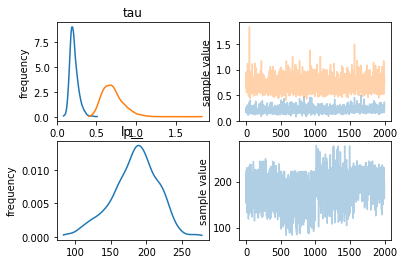

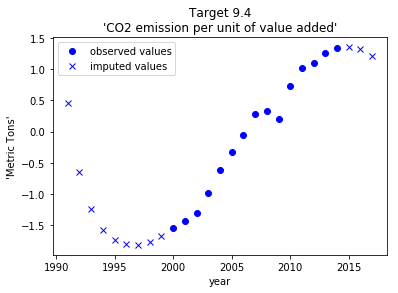

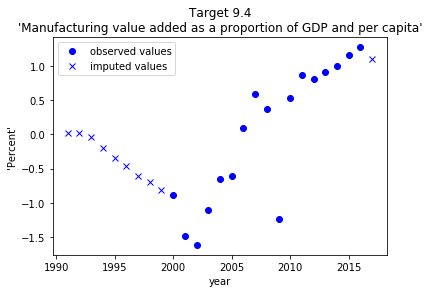

('9.c', '9.2')
Inference for Stan model: anon_model_c2c8db35d3d6b106a2010ff56a7e73b8.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
beta[0,0]     -0.34    0.03   0.32  -0.81  -0.57  -0.39  -0.17   0.45    118   1.02
beta[1,0]    6.9e-3 10.0e-3   0.28  -0.56  -0.18   0.01   0.19   0.57    792    1.0
beta[0,1]      1.14    0.03   0.34   0.35   0.94   1.19   1.39   1.66    122   1.02
beta[1,1]      0.66    0.01   0.29    0.1   0.46   0.66   0.86   1.24    498    1.0
Omega[0,0]      1.0     0.0    0.0    1.0    1.0    1.0    1.0    1.0   2000    nan
Omega[1,0]     0.66    0.02   0.27  -0.01   0.52   0.73   0.87   0.97    190   1.02
Omega[0,1]     0.66    0.02   0.27  -0.01   0.52   0.73   0.87   0.97    190   1.02
Omega[1,1]      1.0 1.4e-185.8e-17    1.0    1.0    1.0    1.0    1.0   1858    nan
tau[0]         0.39    0.01   0.14   0.17 

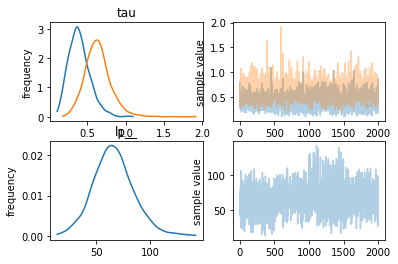

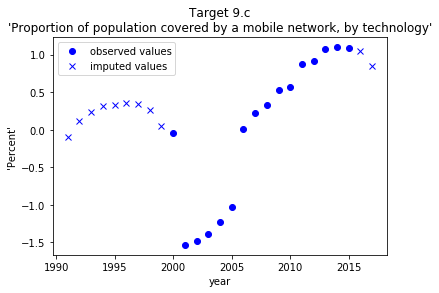

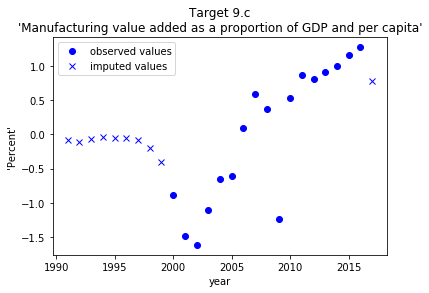

('9.5', '9.4')
Inference for Stan model: anon_model_c2c8db35d3d6b106a2010ff56a7e73b8.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
beta[0,0]     -0.85    0.02   0.15  -1.04  -0.96  -0.88  -0.78  -0.46     97   1.04
beta[1,0]     -0.41    0.01   0.26  -0.87  -0.58  -0.43  -0.26   0.15    364   1.01
beta[0,1]      1.81    0.02   0.16    1.4   1.74   1.85   1.93   2.01     92   1.05
beta[1,1]      1.35    0.01   0.26   0.79   1.19   1.37   1.52   1.81    368    1.0
Omega[0,0]      1.0     0.0    0.0    1.0    1.0    1.0    1.0    1.0   2000    nan
Omega[1,0]     0.46    0.02   0.45   -0.6   0.18   0.58   0.83   0.98    445   1.01
Omega[0,1]     0.46    0.02   0.45   -0.6   0.18   0.58   0.83   0.98    445   1.01
Omega[1,1]      1.0 1.6e-186.6e-17    1.0    1.0    1.0    1.0    1.0   1676    nan
tau[0]         0.07  7.6e-3   0.05   0.01 

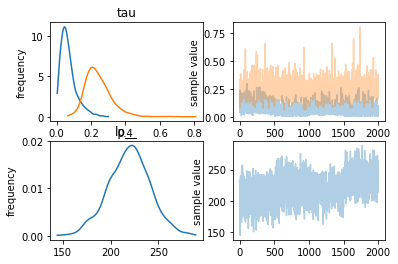

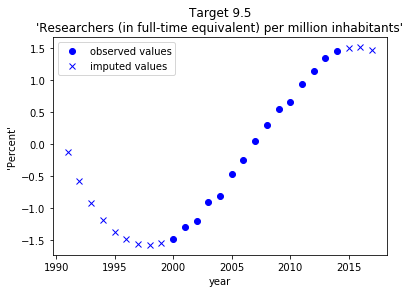

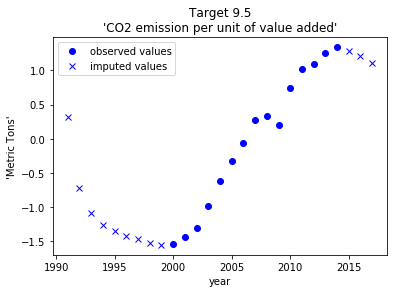

In [51]:
for pair in list(set(bestCorrPairs)):
    targetx = pair[0]
    targety = pair[1]

    # prepare input data
    inData = prepareInputData(clique_df_t, targetx, targety)
    print(pair)

    # run inference using MCMC sampling
    fit = sm.sampling(data=inData, iter=1000, chains=4, algorithm="NUTS", seed=42, verbose=True)
    print(fit)
    
    # what do we actually want to show? sigma and tau are performance measurements.
    fit.plot(["tau","lp__"]) # take vars from temporal model
    plt.show()

    samples = fit.extract(permuted=True)
    
    # get values for plots
    # convert indices back to year values
    ix_mis1 = inData['ix_mis1']+startyear
    ix_mis2 = inData['ix_mis2']+startyear
    ix_obs1 = inData['ix_obs1']+startyear
    ix_obs2 = inData['ix_obs2']+startyear
    
    y_mis1 = samples['y_mis1'].mean(axis=0)
    y_mis2 = samples['y_mis2'].mean(axis=0)
    y_obs1 = inData['y_obs1']
    y_obs2 = inData['y_obs2']
    
    
    # define title and labels from original dataframe
    y1_df = merged_df[merged_df['Target']==pair[0]]
    y2_df = merged_df[merged_df['Target']==pair[1]]
    y1_title = 'Target '+pair[0]+'\n'+str(y1_df['Indicator Description'].values).replace('[','').replace(']','')
    y1_label = str(y1_df['Unit'].values).replace('[','').replace(']','')
    y2_title = 'Target '+pair[0]+'\n'+str(y2_df['Indicator Description'].values).replace('[','').replace(']','')
    y2_label = str(y2_df['Unit'].values).replace('[','').replace(']','')
    
    # plot with imputed values of target 1
    plt.plot(ix_obs1, y_obs1, "bo")
    plt.plot(ix_mis1, y_mis1, "bx")
    plt.title(y1_title)
    plt.legend(["observed values","imputed values"])
    plt.xlabel('year')
    plt.ylabel(y1_label)
    plt.show()
    
    # plot with imputed values of target 2
    plt.plot(ix_obs2, y_obs2, "bo")
    plt.plot(ix_mis2, y_mis2, "bx")
    plt.title(y2_title)
    plt.legend(["observed values", "imputed values"])
    plt.xlabel('year')
    plt.ylabel(y2_label)
    plt.show()

## Open questions: What we haven't understood so far

- Omega[1,0] is a value of Omega that gives us the correlation between Target 1 and 2. What kind of correlation measure is it? How can it be different/lower from our previously found Pearson r?
